# Table of Content 
1. Import Libraries & Data 
2. Subsetting, wrangling, and cleaning time-series data
3. Time-series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Federal Reserve Economic Data

# 1. Import Liraries & Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings 
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight') 

In [2]:
quandl.ApiConfig.api_key = 'auGJDHNy6wcqNjzTo-Eb'

In [3]:
# Importing the Federal Reserve Economic Data "Consumer Price Index for All Urban Consumers: All Items" variable.
data = quandl.get('FRED/CPIAUCSL')

In [4]:
data.head()

Value
Date             
1947-01-01  21.48
1947-02-01  21.62
1947-03-01  22.00
1947-04-01  22.00
1947-05-01  21.95

In [5]:
data.shape

(901, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter
df = data.reset_index()

In [10]:
df.head()

Date  Value
0 1947-01-01  21.48
1 1947-02-01  21.62
2 1947-03-01  22.00
3 1947-04-01  22.00
4 1947-05-01  21.95

In [11]:
df_sub = df.loc[(df['Date'] >= '2000-01-01')]

In [12]:
df_sub.shape

(265, 2)

In [13]:
df_sub.head()

Date  Value
636 2000-01-01  169.3
637 2000-02-01  170.0
638 2000-03-01  171.0
639 2000-04-01  170.9
640 2000-05-01  171.2

In [14]:
# Check for missing values (you shouldn't have any)
df_sub.isnull().sum()
#no missing values

Date     0
Value    0
dtype: int64

In [15]:
# Check for duplicates
dups = df_sub.duplicated()
dups.sum()
#0 duplicates found 

0

In [16]:
# Set the "Date" column as the index.
from datetime import datetime
df_sub['datetime'] = pd.to_datetime(df_sub['Date']) 
df_sub = df_sub.set_index('datetime')  
df_sub.drop(['Date'], axis=1, inplace=True) 
df_sub.head()

Value
datetime         
2000-01-01  169.3
2000-02-01  170.0
2000-03-01  171.0
2000-04-01  170.9
2000-05-01  171.2

In [17]:
plt.figure(figsize=(15,5), dpi=100) 
    

plt.plot(df_sub)

# 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [19]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

In [20]:
# Plot the separate components
decomposition.plot()
plt.show()

## Discussion: 
The visualization shows that that CPI has increased throughout the years with the exception on 2008 due to the housing recession.

# 4. Testing for stationarity

In [22]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.345940
p-value                          0.996854
Number of Lags Used              2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


## Discussion: 
Based on the Dickey-Fuller test this time series are non - stationari. The Critical Value (10%) is biger than the Statistic Test. 

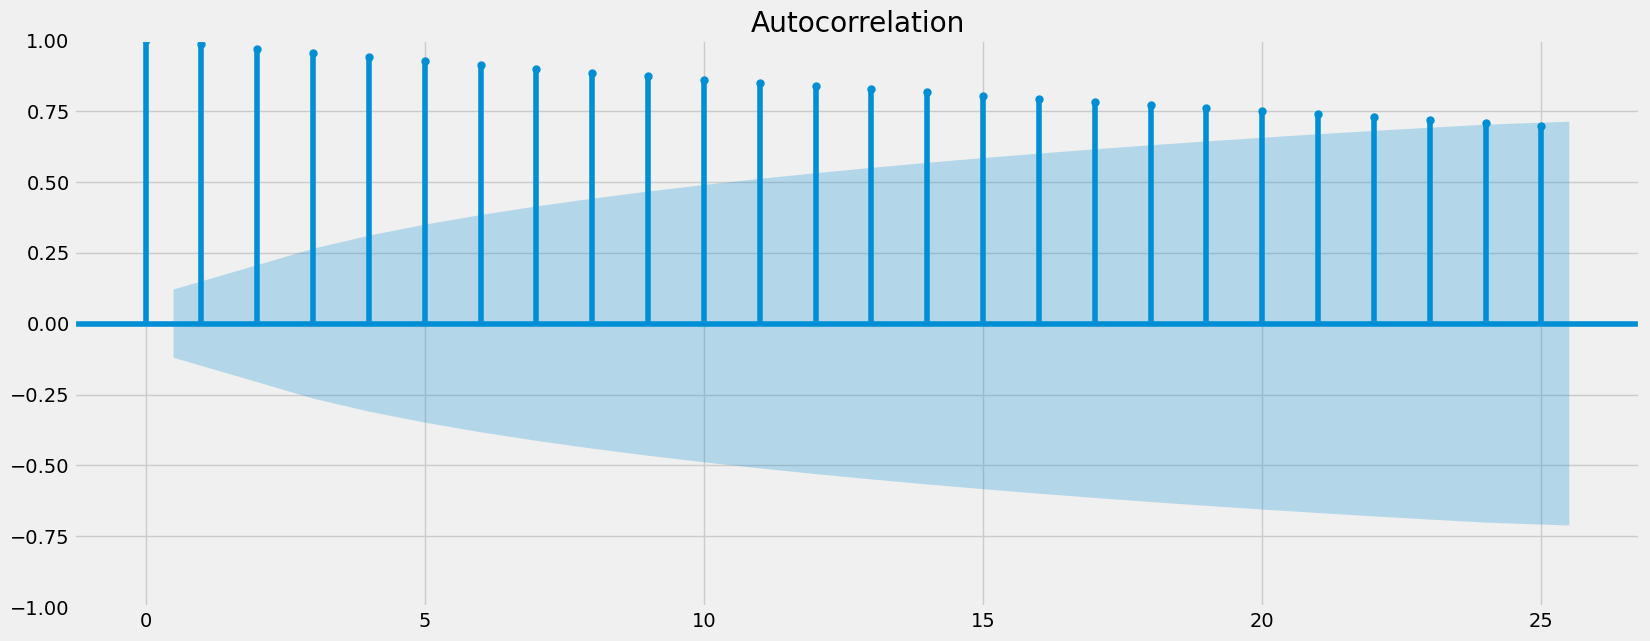

In [23]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots\n",

plot_acf(df_sub)
plt.show()

## Discussion: 
The visualizations above shows more than 10 lags above the confidence interval. This means that there is a lot of autocorrelated data and further proofs the that Dickey-Fuller test is correct. 

# 5. Stationarizing the Federal Reserve Economic Data

In [28]:
df_diff = df_sub - df_sub.shift(1)

In [29]:
df_diff.dropna(inplace = True) 

In [30]:
df_diff.head()

Value
datetime         
2000-02-01    0.7
2000-03-01    1.0
2000-04-01   -0.1
2000-05-01    0.3
2000-06-01    1.0

In [31]:
df_diff.columns

Index(['Value'], dtype='object')

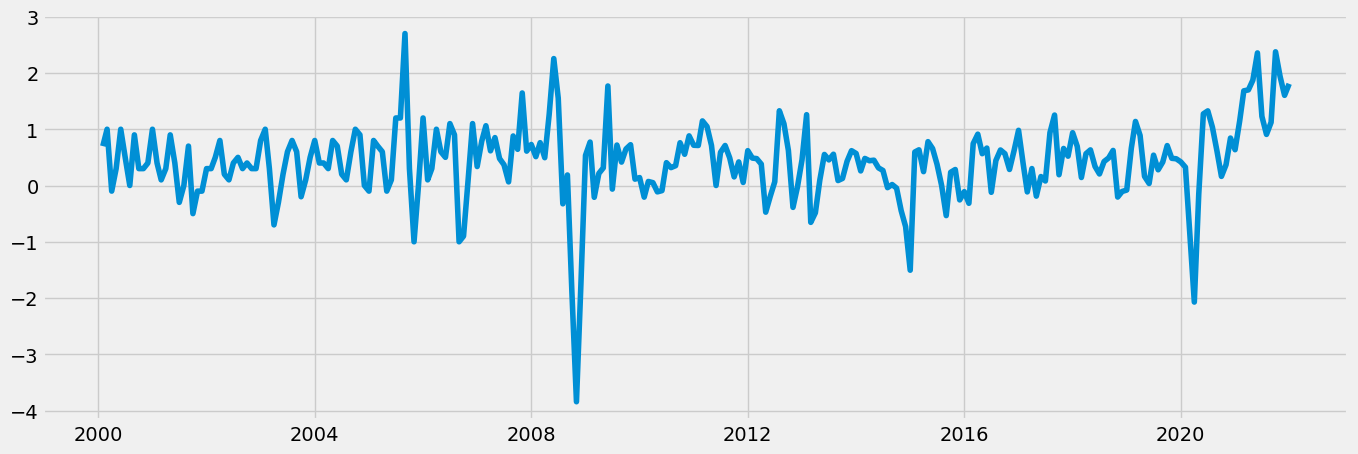

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [33]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.570757e+00
p-value                        2.291720e-16
Number of Lags Used            1.000000e+00
Number of Observations Used    2.620000e+02
Critical Value (1%)           -3.455558e+00
Critical Value (5%)           -2.872636e+00
Critical Value (10%)          -2.572683e+00
dtype: float64


In [34]:
plot_acf(df_diff)
plt.show()

# Discussion:
After tautomerizing the data, the Critical Value (10%) is less than the Test Statistic. This means that data is now stationary. 
In addition, based on the autocorrelation visualization we can see less than 10 lags above the confidence interval; however, the stationarity is weak. 